In [1]:
from typing import Optional
import numpy as np
from scipy.stats import chisquare, binom
import pandas as pd
import plotnine as gg
import re
from main import make_format_number
import utils
from IPython.display import display, HTML
pd.set_option('display.html.use_mathjax', False)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

%matplotlib inline

In [2]:
green = np.array([27,158,119])/256
orange = np.array([217,95,2])/256
purple = np.array([117,112,179])/256
pink = np.array([231,41,138])/256

# Section 3

In [3]:
df = pd.concat([pd.read_csv('results/20230407_gpt35_comma_effects.csv', index_col=0),
                pd.read_csv('results/20230518_gpt_other_delimiters.csv', index_col=0)])
# drop corrupted foo_ results
df = df[(df['problem_number_format'].str.startswith('foo') == False)]

df['system_prompt_type'] = df.apply(lambda x: 'custom' if 'MathGPT' in x.system_prompt else 'original', axis=1)
mathgpt_df = df[(df['num_shots']<=8) & (df['system_prompt_type'] == 'custom')]
df = df[(df['num_shots']<=8) & (df['system_prompt_type'] == 'original')]

In [4]:
df = utils.post_process_df(df)
df = df[df['valid_answer']]

## Figure in Section 3.1

[0.9555555555555556, 0.9777777777777777, 0.9666666666666667, 0.9777777777777777] [0.7061068702290076, 0.737037037037037, 0.7481481481481481, 0.7555555555555555]


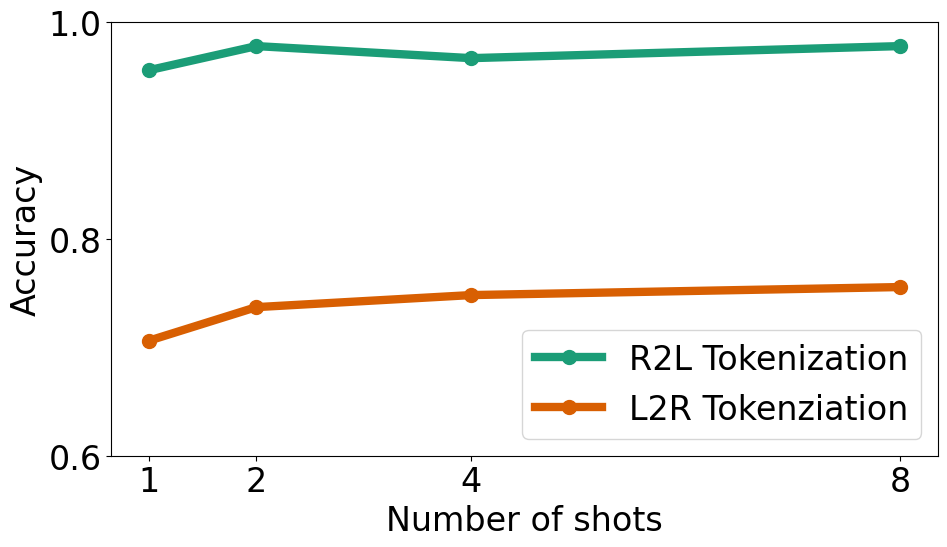

In [5]:
# Figure for R2L vs L2R
nosep_means = []
comma_means = []
shots = [1,2,4,8]
for num_shots in shots:
    comma_data = df.loc[(df['problem_number_format'] == 'comma_r2l') & 
                        (df['num_shots'] == num_shots)]['answer_match'].to_numpy()
    nosep_data = df.loc[(df['problem_number_format'] == 'nosep') & 
                        (df['num_shots'] == num_shots)]['answer_match'].to_numpy()
    comma_means.append(np.mean(comma_data))
    nosep_means.append(np.mean(nosep_data))
    
fig, axs = plt.subplots()
fig.set_size_inches(10, 6)
axs.plot(shots, comma_means, color=green, label='R2L Tokenization', 
         lw=6, marker='o', markersize=10)
axs.plot(shots, nosep_means, color=orange, label='L2R Tokenziation', 
         lw=6, marker='o', markersize=10)
axs.legend(loc='lower right')
axs.set_xlabel('Number of shots')
axs.set_ylabel('Accuracy')
axs.set_ylim([0.6, 1])
axs.set_yticks([0.6, 0.8, 1])
axs.set_xticks([1, 2, 4, 8])
plt.tight_layout()
fig.savefig('figures/r2l_v_l2r_w_shots.pdf')
print(comma_means, nosep_means)

### Figure in Appendix B

In [6]:
mathgpt_df = utils.post_process_df(mathgpt_df)
mathgpt_df = mathgpt_df[mathgpt_df['valid_answer']]

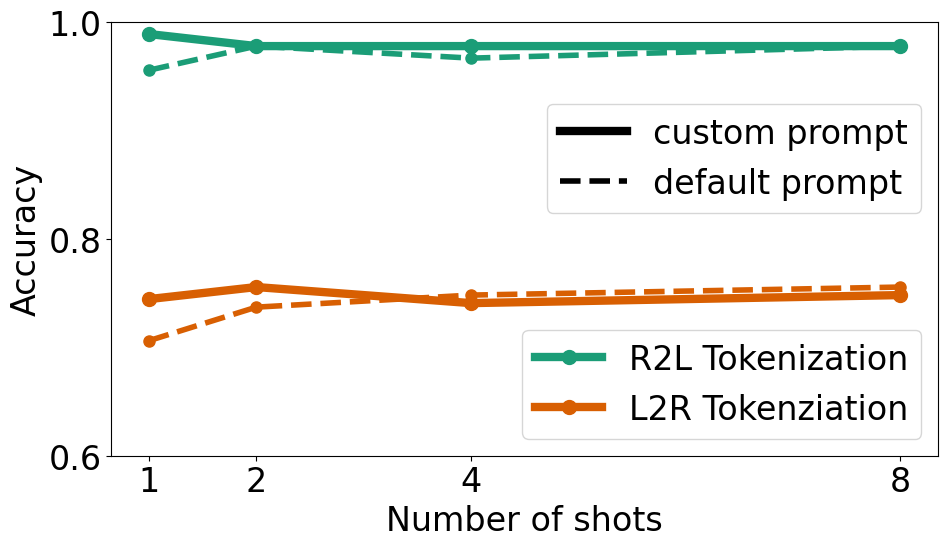

In [7]:
mgpt_nosep_means = []
mgpt_comma_means = []
shots = [1,2,4,8]
for num_shots in shots:
    comma_data = mathgpt_df.loc[(mathgpt_df['problem_number_format'] == 'comma_r2l') & 
                                (mathgpt_df['num_shots'] == num_shots)]['answer_match'].to_numpy()
    nosep_data = mathgpt_df.loc[(mathgpt_df['problem_number_format'] == 'nosep') & 
                                (mathgpt_df['num_shots'] == num_shots)]['answer_match'].to_numpy()
    mgpt_comma_means.append(np.mean(comma_data))
    mgpt_nosep_means.append(np.mean(nosep_data))
    
fig, axs = plt.subplots()
fig.set_size_inches(10, 6)
axs.plot(shots, comma_means, color=green,
         lw=4, marker='o', markersize=8, ls='--')
line1 = axs.plot(shots, mgpt_comma_means, color=green, label='R2L Tokenization', 
         lw=6, marker='o', markersize=10)
axs.plot(shots, nosep_means, color=orange,
         lw=4, marker='o', markersize=8, ls='--')
line2 = axs.plot(shots, mgpt_nosep_means, color=orange, label='L2R Tokenziation', 
         lw=6, marker='o', markersize=10)

fake1 = axs.plot([20, 21], [20, 21], ls='--', c= 'k', lw=4, label='default prompt')
fake2 = axs.plot([20, 21], [20, 21], c='k', lw=6, label='custom prompt')

legend2 = axs.legend(handles=[fake2[0], fake1[0]], 
                     bbox_to_anchor=(0.5, 0.35, 0.5, 0.5), loc='upper right')
legend2.get_title().set_multialignment('center')

axs.add_artist(legend2)

legend1 = axs.legend(handles=[line1[0], line2[0]], loc='lower right')


axs.set_xlabel('Number of shots')
axs.set_ylabel('Accuracy')
axs.set_ylim([0.6, 1])
axs.set_xlim([0.65, 8.35])
axs.set_yticks([0.6, 0.8, 1])
axs.set_xticks([1, 2, 4, 8])
plt.tight_layout()
fig.savefig('figures/r2l_v_l2r_w_shots_v_mathgpt.pdf')

## Figure in Section 3.2: Delimiter control

In [8]:
def make_problem_format_string(problem_number_format: str, num_spaces: int):
	if num_spaces > 0:
		return problem_number_format + f'+{num_spaces}'
	else:
		return problem_number_format
df['problem_format'] = df.apply(lambda x: make_problem_format_string(x.problem_number_format, x.num_spaces), axis=1)

In [9]:
avg_df = df.groupby(['model', 'problem_format', 'system_prompt_type', 'num_shots'])[['answer_match', 'format_match', 'formatted_answer_match', 'valid_answer']].agg([np.mean, np.sum]).reset_index()
avg_df.columns = ['_'.join(col).rstrip('_') for col in avg_df.columns]
avg_df['problem_format'] = avg_df['problem_format'].astype('category')
print(avg_df['problem_format'].cat.categories)
avg_df['problem_format'] = avg_df['problem_format'].cat.reorder_categories(
    ['comma_r2l', 'space_r2l', 'dec_r2l', 'dollar_r2l', 'hashtag_r2l',
     'nosep', 'nosep+1', 'nosep+2',
     'comma_l2r', 'space_l2r', 'dec_l2r', 'dollar_l2r', 'hashtag_l2r'])

Index(['comma_l2r', 'comma_r2l', 'dec_l2r', 'dec_r2l', 'dollar_l2r',
       'dollar_r2l', 'hashtag_l2r', 'hashtag_r2l', 'nosep', 'nosep+1',
       'nosep+2', 'space_l2r', 'space_r2l'],
      dtype='object')


In [10]:
delim_controls = dict()
for i, row in avg_df[avg_df['num_shots'] == 8].iterrows():
    delim_controls[row['problem_format']] = row['answer_match_mean']
print(delim_controls)

{'comma_l2r': 0.2777777777777778, 'comma_r2l': 0.9777777777777777, 'dec_l2r': 0.3, 'dec_r2l': 0.9888888888888889, 'dollar_l2r': 0.3111111111111111, 'dollar_r2l': 0.9777777777777777, 'hashtag_l2r': 0.28888888888888886, 'hashtag_r2l': 0.9555555555555556, 'nosep': 0.7444444444444445, 'nosep+1': 0.7555555555555555, 'nosep+2': 0.7666666666666667, 'space_l2r': 0.2777777777777778, 'space_r2l': 0.9666666666666667}


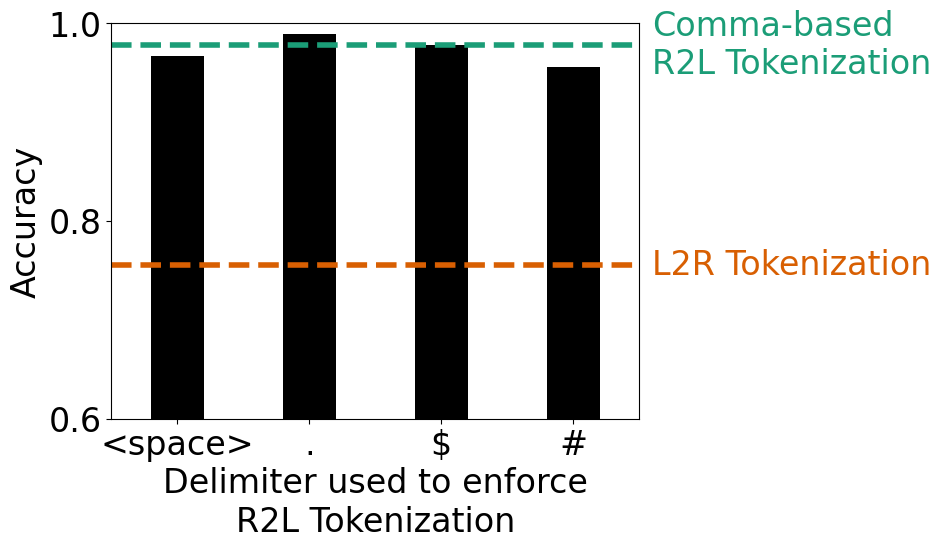

In [11]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

order = ['space_r2l', 'dec_r2l', 'dollar_r2l', 'hashtag_r2l']
x = np.arange(len(order))

axs.bar(x, [delim_controls[o] for o in order], width=0.4, color='k')
axs.set_xlim(-0.5, len(x)-0.5)
axs.set_xticks(x, ['<space>', ".", "$", "#"])
axs.set_xlabel('Delimiter used to enforce\nR2L Tokenization')
axs.set_ylim(0.6, 1)
axs.set_yticks([0.6, 0.8, 1])
axs.set_ylabel("Accuracy")
axs.axhline(delim_controls['comma_r2l'], color=green, ls='--', lw=4)
axs.axhline(nosep_means[-1], color=orange, ls='--', lw=4)

x_min, x_max = axs.get_xlim()
# Add text on the right of the horizontal line
axs.text(x_max+0.1, delim_controls['comma_r2l'], 
         'Comma-based\nR2L Tokenization', va='center', ha='left',
        color=green)
axs.text(x_max+0.1, nosep_means[-1], 
         'L2R Tokenization', va='center', ha='left',
        color=orange)
plt.tight_layout()
fig.savefig('figures/control_delimiter.pdf')

## Figure in Section 3.3: Thinking token control

In [12]:
df[(df['num_shots'] == 8) & (df['problem_index'] == 40)][['problem_format', 'prompt_tokens']]

,problem_format,prompt_tokens
3460,nosep,195
3910,nosep+1,213
4360,nosep+2,240
4810,comma_r2l,247
5260,comma_l2r,247
5710,space_r2l,247
6160,space_l2r,247
310,dec_r2l,247
670,dec_l2r,247
1030,hashtag_r2l,247


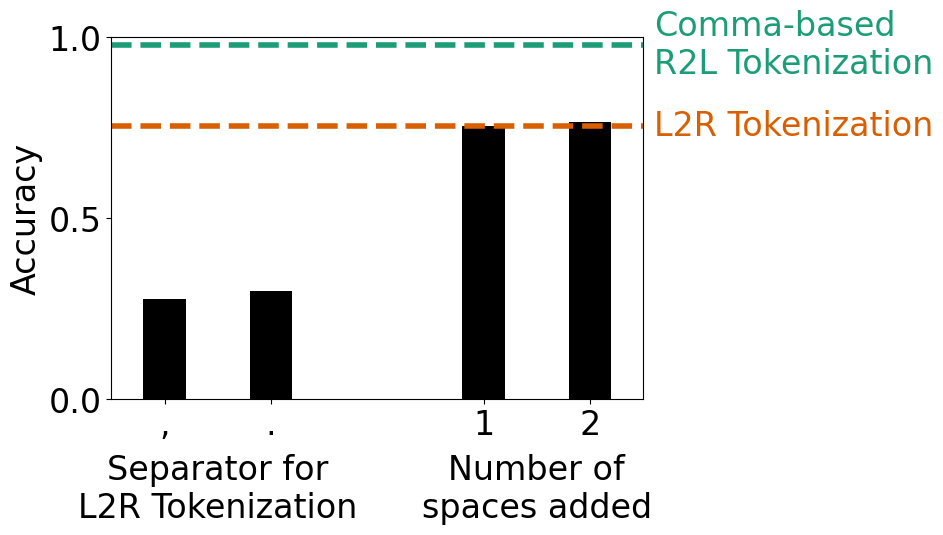

In [13]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

order = ['comma_l2r', 'dec_l2r', 'nosep+1', 'nosep+2']
x = [0, 1, 3, 4]

axs.bar(x, [delim_controls[o] for o in order], width=0.4, color='k')
axs.set_xlim(-0.5, x[-1]+0.5)
axs.set_xticks(x, [",", ".", '1', '2'])
axs.set_yticks([0, 0.5, 1])
axs.set_ylabel("Accuracy")
axs.axhline(delim_controls['comma_r2l'], color=green, ls='--', lw=4)
axs.axhline(nosep_means[-1], color=orange, ls='--', lw=4)

x_min, x_max = axs.get_xlim()
y_min, y_max = axs.get_ylim()
# Add text on the right of the horizontal line
axs.text(x_max+0.1, delim_controls['comma_r2l'], 
         'Comma-based\nR2L Tokenization', va='center', ha='left',
        color=green)
axs.text(x_max+0.1, nosep_means[-1], 
         'L2R Tokenization', va='center', ha='left',
        color=orange)

axs.text(0.5, y_min-0.15, 
         'Separator for\nL2R Tokenization', va='top', ha='center',
        color='k')
axs.text(3.5, y_min-0.15, 
         'Number of\nspaces added', va='top', ha='center',
        color='k')
plt.tight_layout()
fig.savefig('figures/control_thinking_token.pdf')

# Section 4

In [14]:
df = pd.read_csv('results/20240125_gpt35_0301_answer_length_effects.csv', index_col=0)
df = utils.post_process_df(df)
# We don't filter by valid here since only 1 nosep problem was invalid, and we actually
# keep this in the plot later on just to illustrate
df['system_prompt_type'] = df.apply(lambda x: 'custom' if 'MathGPT' in x.system_prompt else 'original', axis=1)

In [15]:
df = pd.concat([utils.add_error_analysis(df[df['problem_number_format'] == 'nosep']),
               utils.add_error_analysis(df[df['problem_number_format'] == 'comma_r2l'], tokenize_dir='r2l')],
              axis=0)

## Section 4.1: Length mismatch

In [16]:
df.groupby(['problem_number_format', 'len_match'])[['answer_match', 'formatted_answer_match', 'format_match', 'extraneous_response', 'dropped_digit_error']].agg([np.mean, np.sum])

answer_match      formatted_answer_match        
                                        mean  sum                   mean  sum   
problem_number_format len_match                                                 
comma_r2l             False         0.985000  394               0.985000  394  \
                      True          0.978889  881               0.978889  881   
nosep                 False         0.082500   33               0.082500   33   
                      True          0.937778  844               0.937778  844   

                                format_match      extraneous_response       
                                        mean  sum                mean sum   
problem_number_format len_match                                             
comma_r2l             False           1.0000  400              0.0000   0  \
                      True            1.0000  900              0.0000   0   
nosep                 False           0.9975  399              0.0025   1   
                      True            1.0000  900              0.0000   0   

                                dropped_digit_error      
                                               mean sum  
problem_number_format len_match                          
comma_r2l             False                     0.0   0  
                      True                      0.0   0  
nosep                 False                     0.0   0  
                      True                 0.001111   1

In [17]:
# We want to make a bar plot with four numbers:
# Comma_r2l and nosep on ans_match and not ans_match
# They'll be plotted as two separate series

series = dict()
for f in ['nosep', 'comma_r2l']:
    series[f] = [df[(df['problem_number_format'] == f) & 
                    (df['len_match'] == b)]['answer_match'].mean()
                for b in [True, False]]
print(series)

{'nosep': [0.9377777777777778, 0.0825], 'comma_r2l': [0.9788888888888889, 0.985]}


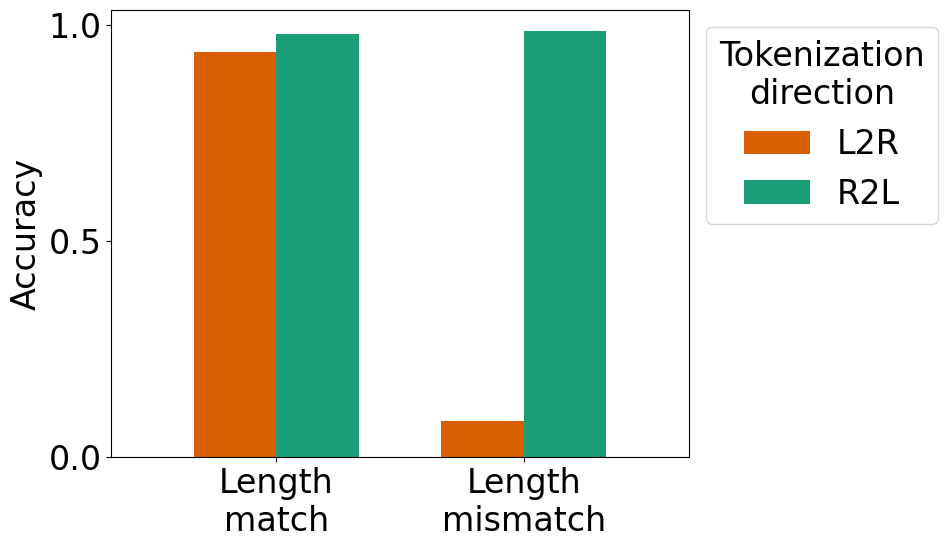

In [18]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

x = np.array([0, 3])
axs.bar(x-0.5, series['nosep'], width=1, color=orange, label='L2R')
axs.bar(x+0.5, series['comma_r2l'], width=1, color=green, label='R2L')
axs.set_xlim(-2, 5)

axs.set_xticks(x, ['Length\nmatch', 'Length\nmismatch'])
axs.set_yticks([0, 0.5, 1])
axs.set_ylabel("Accuracy")
axs.legend(bbox_to_anchor=(1,1), title='Tokenization\ndirection').get_title().set_multialignment('center')

plt.tight_layout()
fig.savefig('figures/answer_length_error.pdf')

## Section 4.2: Carry control

We consider the confound of number of carries on problems when using R2L tokenization or L2R tokenization with length match. If more carries is *generally harder* for the model, it could explain the lower accuracy in the L2R tokenization length mismatch condition. We look at the three bars above with good accuracy to see if number of carries is generally an error mechanism or not

In [19]:
df_len_match = df[df['len_match']]
df_comma = df[df['problem_number_format'] == 'comma_r2l']
df_nosep = df_len_match[df_len_match['problem_number_format'] == 'nosep']

df_comma_wrong = df_comma[df_comma['answer_match'] == False]
df_nosep_wrong = df_nosep[df_nosep['answer_match'] == False]
len(df_comma_wrong), len(df_nosep_wrong)

(25, 56)

Note, we filter out carry numbers with less than 50 problems. Since we didn't control for # of carries, we computed the number of carries present for the problems in our dataset. There were only 6 problems with no carries, and 4 problems with 8 carries. These sample sizes are too small to draw any conclusions (on the other hand, for 1 and 7 carries, the # of problems is 66 and 57 respectively)

In [20]:
comma_carry_all = df.groupby('num_carries')['problem_index'].nunique().to_dict()
comma_carry_wrong = df_comma_wrong.groupby('num_carries')['problem_index'].nunique().to_dict()
all_carry_poss = sorted(list([i for i in comma_carry_all if comma_carry_all[i] > 50]))
comma_carry_wrong_fracs = [comma_carry_wrong.get(i, 0)/comma_carry_all[i] for i in all_carry_poss]
comma_carry_wrong_fracs

[0.015151515151515152,
 0.01675977653631285,
 0.022222222222222223,
 0.023529411764705882,
 0.008403361344537815,
 0.02142857142857143,
 0.0]

In [21]:
nosep_carry_all = df_len_match.groupby('num_carries')['problem_index'].nunique().to_dict()
nosep_carry_wrong = df_nosep_wrong.groupby('num_carries')['problem_index'].nunique().to_dict()
nosep_carry_wrong_fracs = [nosep_carry_wrong.get(i, 0)/nosep_carry_all.get(i, 1) for i in all_carry_poss]
nosep_carry_wrong_fracs

[0.06153846153846154,
 0.07142857142857142,
 0.04225352112676056,
 0.05,
 0.08450704225352113,
 0.1016949152542373,
 0.05]

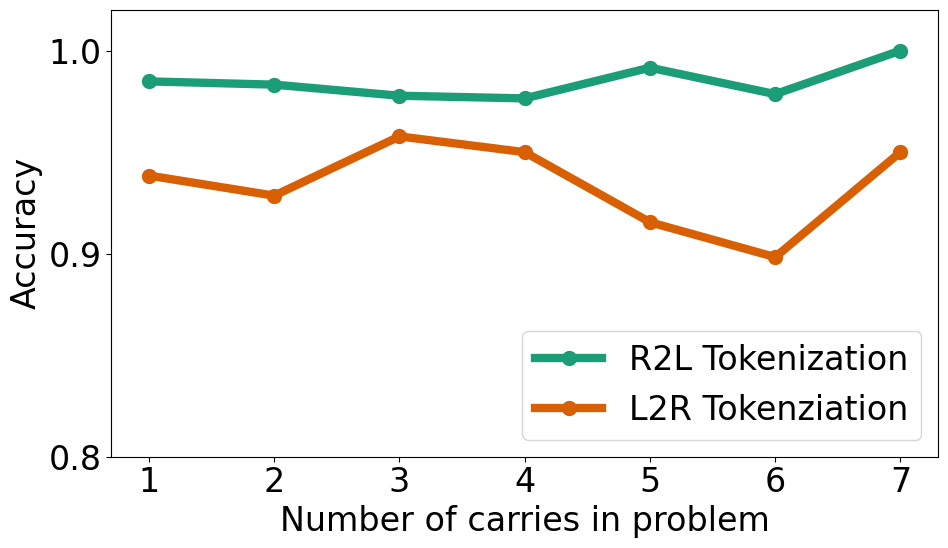

In [22]:
fig, axs = plt.subplots()
fig.set_size_inches(10, 6)
axs.plot(all_carry_poss, 1-np.array(comma_carry_wrong_fracs), color=green, label='R2L Tokenization', 
         lw=6, marker='o', markersize=10)
axs.plot(all_carry_poss, 1-np.array(nosep_carry_wrong_fracs), color=orange, label='L2R Tokenziation', 
         lw=6, marker='o', markersize=10)
axs.legend(loc='lower right')
axs.set_xlabel('Number of carries in problem')
axs.set_ylabel('Accuracy')
axs.set_ylim([0.8, 1.02])
axs.set_yticks([0.8, 0.9, 1])
axs.set_xticks(all_carry_poss)
plt.tight_layout()
fig.savefig('figures/num_carries.pdf')

## Section 4.3: Digit 4 errors

We dig into the specific error that might be happening in the length mismatch condition when using L2R tokenization

In [23]:
df_nosep_nolenmatch = df[(df['problem_number_format'] == 'nosep') & (df['len_match'] == False)]

In [24]:
len(df_nosep_nolenmatch)

400

In [25]:
df_nosep_nolenmatch_wrong = df_nosep_nolenmatch[df_nosep_nolenmatch['answer_match'] == False]

In [26]:
len(df_nosep_nolenmatch_wrong)

367

In [27]:
(df_nosep_nolenmatch_wrong['correct_ans_len'] == True).sum()

365

In [28]:
df_nosep_nolenmatch_wrong[df_nosep_nolenmatch_wrong['correct_ans_len'].isna()][['problem_index', 'num1','num2','true_answer','response']]

,problem_index,num1,num2,true_answer,response
339,339,1065217,9576905,10642122,1065217+9576905=1065217+9576905=1065217+


In [29]:
df_nosep_nolenmatch_wrong[df_nosep_nolenmatch_wrong['correct_ans_len'] == False][['problem_index', 'num1','num2','true_answer','response']]

,problem_index,num1,num2,true_answer,response
785,785,96189346,9286178,105475524,10567524


Mostly, the model gets the right output answer length. On one problem it doesn't answer properly. On the other, it has one fewer digit in the output.

For looking at digit errors, these aren't really valid responses so we exclude them

In [30]:
labels = [str(i) for i in range(1,10)] + ['Other', 'None']

errors_by_digit = [df_nosep_nolenmatch_wrong[df_nosep_nolenmatch_wrong['correct_ans_len'] == True]['digit_{}_error'.format(digit)].sum()/len(df_nosep_nolenmatch) for digit in range(1, 10)]
errors_by_digit.append((len(df_nosep_nolenmatch_wrong) - df_nosep_nolenmatch_wrong['correct_ans_len'].sum())/len(df_nosep_nolenmatch))
errors_by_digit.append(1- len(df_nosep_nolenmatch_wrong)/len(df_nosep_nolenmatch))
print(errors_by_digit)

[0.0, 0.0, 0.0, 0.9125, 0.0025, 0.0075, 0.0025, 0.0, 0.0, 0.005, 0.08250000000000002]


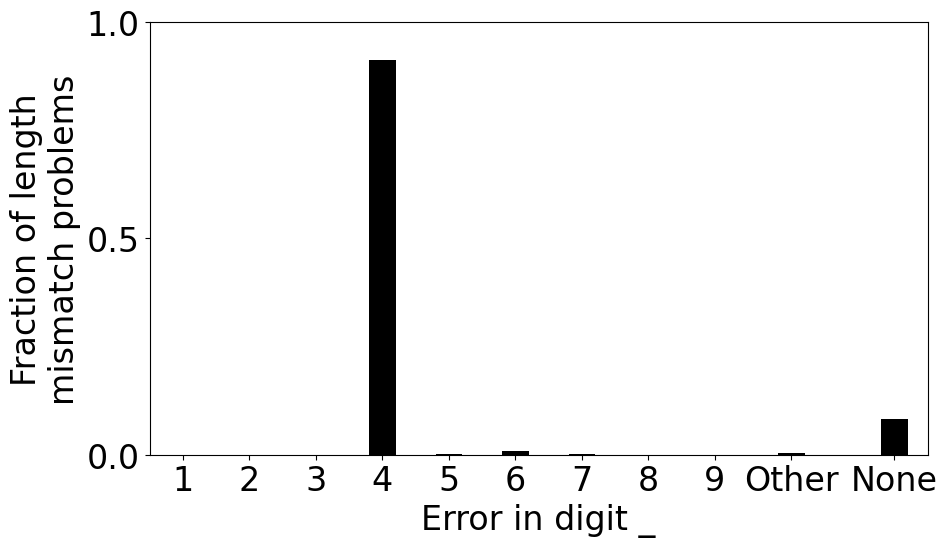

In [31]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

x = np.arange(len(labels), dtype=float)
x[-1] += 0.7
x[-2] += 0.15

axs.bar(x, errors_by_digit, width=0.4, color='k')
axs.set_xlim(-0.5, x[-1]+0.5)
axs.set_xticks(x, labels)
axs.set_ylim(0, 1)
axs.set_yticks([0, 0.5, 1])
axs.set_ylabel("Fraction of length\nmismatch problems")
axs.set_xlabel("Error in digit _")

plt.tight_layout()
fig.savefig('figures/len_mismatch_nosep_digit4.pdf', bbox_inches='tight', pad_inches=0)

In [32]:
df_nosep_nolenmatch_wrong_correctlen = df_nosep_nolenmatch_wrong[df_nosep_nolenmatch_wrong['correct_ans_len'] == True]

In [33]:
mags_off = df_nosep_nolenmatch_wrong_correctlen.groupby('digit_4_error_mag')['problem_index'].nunique().to_dict()
raw_mags = np.array([mags_off[i] for i in range(1, 10)])
all_mags = raw_mags/len(df_nosep_nolenmatch_wrong_correctlen)

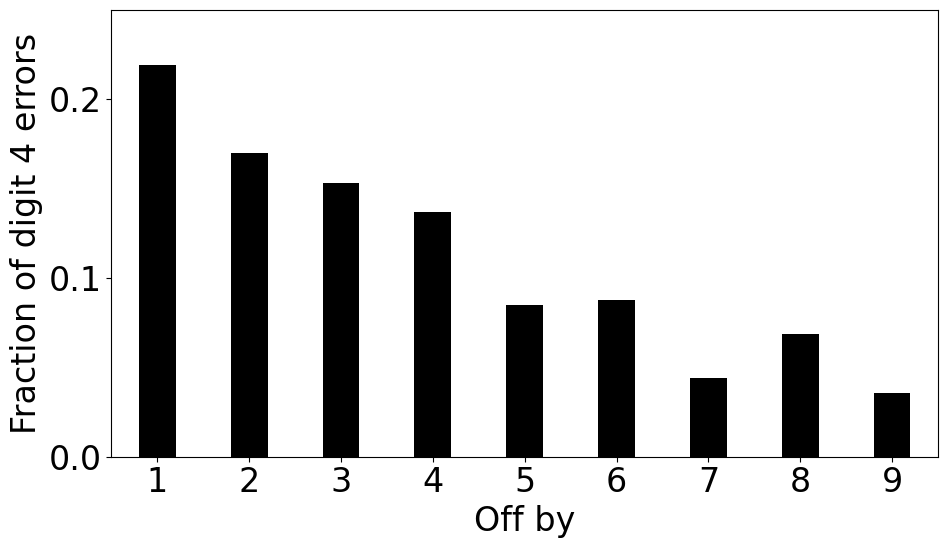

In [34]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

x = np.arange(len(all_mags))

axs.bar(x, all_mags, width=0.4, color='k')
axs.set_xlim(-0.5, x[-1]+0.5)
axs.set_xticks(x, [str(i) for i in range(1, 10)])
axs.set_ylim([0, 0.25])
axs.set_yticks([0, 0.1, 0.2])
axs.set_ylabel("Fraction of digit 4 errors")
axs.set_xlabel("Off by")

plt.tight_layout()
fig.savefig('figures/len_mismatch_nosep_digit4_offby.pdf', bbox_inches='tight', pad_inches=0)

## Section 4.4: Other errors are mostly off-by-one

In [35]:
len(df_comma_wrong), len(df_nosep_wrong)

(25, 56)

In [36]:
df_comma_wrong['only_off_by_one'].to_numpy().astype(int).sum(), df_nosep_wrong['only_off_by_one'].to_numpy().astype(int).sum()
# Out of (25, 56) mistakes made

(24, 53)

In [37]:
(df_nosep_wrong['only_off_by_one_digit_num'] % 3 == 0).sum()

51

In [38]:
((df_comma_wrong['len_true_ans'] - df_comma_wrong['only_off_by_one_digit_num']) % 3 == 0).sum()

24

Verified claims made in Section 4.4 second paragraph above... didn't really make a figure out of these since felt best presented in text.

# Section 5: Repeat experiments

## Section 5.1 Repeat figure

In [39]:
# read and process data
df = pd.read_csv('results/20230524_gpt_comma_effects_repeat_style_triplets.csv', index_col=0)
df = utils.post_process_df(df)
df['repeat_problem_number_format'] = df['repeat_problem_number_format'].replace({np.nan: 'none'})

prompt_names = {df['system_prompt'].unique()[0]: 'default',
                df['system_prompt'].unique()[1]: 'MathGPT',
                df['system_prompt'].unique()[2]: 'MathGPT repeat'}

df['system_prompt_type'] = df.apply(lambda x: prompt_names[x.system_prompt], axis=1)

def make_problem_format_string(
		problem_number_format: str,
		repeat_problem_number_format: str,
		answer_number_format: str):
	return problem_number_format + ' -> ' + repeat_problem_number_format + ' -> ' + answer_number_format

df['problem_format'] = df.apply(lambda x: make_problem_format_string(x.problem_number_format, x.repeat_problem_number_format, x.answer_number_format), axis=1)

avg_df = df.groupby(['problem_format', 'system_prompt_type', 'num_shots'])[['answer_match', 'format_match', 'repeat_copy_match', 'repeat_format_match', 'extraneous_response']].agg([np.mean, np.sum]).reset_index()
avg_df.columns = ['_'.join(col).rstrip('_') for col in avg_df.columns]

avg_df['problem_format'] = avg_df['problem_format'].astype('category')
avg_df['problem_format'] = avg_df['problem_format'].cat.reorder_categories(
    ['comma_r2l -> comma_r2l -> comma_r2l',
     'comma_r2l -> none -> comma_r2l',
     'nosep -> comma_r2l -> comma_r2l',
     'comma_r2l -> nosep -> comma_r2l',
     'comma_r2l -> nosep -> nosep',
     'nosep -> comma_r2l -> nosep',
     'nosep -> none -> nosep',
     'nosep -> nosep -> nosep'])

problem_formats = {
  'comma_r2l -> comma_r2l -> comma_r2l': 'R2L -> R2L',
  'comma_r2l -> nosep -> nosep': 'R2L -> L2R',
  'nosep -> comma_r2l -> comma_r2l': 'L2R -> R2L',
  'nosep -> nosep -> nosep': 'L2R -> L2R',
}
filtered_df = avg_df[(avg_df['system_prompt_type'] == 'default') & (avg_df['problem_format'].isin(problem_formats.keys()))]
filtered_df['problem_format'] = filtered_df['problem_format'].cat.remove_unused_categories()
filtered_df['problem_format'] = filtered_df['problem_format'].cat.rename_categories(problem_formats)

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_30026/3889768106.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_30026/3889768106.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


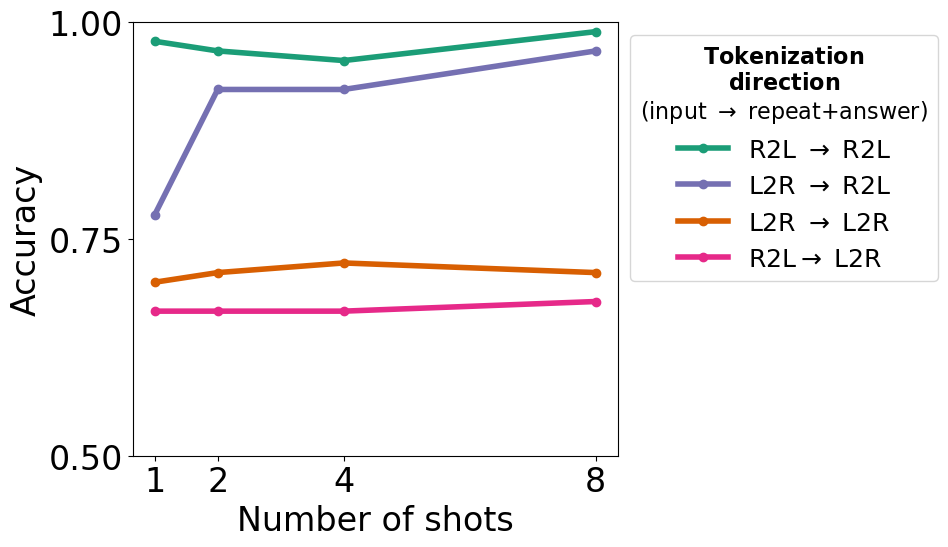

In [40]:
save_fig = False
plot_dict = {}
shots = [1,2,4,8]
for problem_format in problem_formats.values():
    plot_dict[problem_format] = []
    for num_shots in shots:
        plot_dict[problem_format].append(filtered_df.loc[(filtered_df['problem_format'] == problem_format) & (filtered_df['num_shots'] == num_shots)]['answer_match_mean'].to_numpy()[0])
    
fig, axs = plt.subplots()
fig.set_size_inches(10, 6)
axs.plot(shots, plot_dict['R2L -> R2L'], color=green, label='R2L $\\rightarrow$ R2L', lw=4, marker='o')
axs.plot(shots, plot_dict['L2R -> R2L'], color=purple, label='L2R $\\rightarrow$ R2L', lw=4, marker='o')
axs.plot(shots, plot_dict['L2R -> L2R'], color=orange, label='L2R $\\rightarrow$ L2R', lw=4, marker='o')
axs.plot(shots, plot_dict['R2L -> L2R'], color=pink, label='R2L$\\rightarrow$ L2R', lw=4, marker='o')
axs.legend(bbox_to_anchor=(1,1), fontsize=18, title='$\\bf{Tokenization}$\n$\\bf{direction}$\n(input $\\rightarrow$ repeat+answer)', title_fontsize=16).get_title().set_multialignment('center')

axs.set_xlabel('Number of shots')
axs.set_ylabel('Accuracy')
axs.set_ylim([0.6, 1])
axs.set_yticks([0.5, 0.75, 1])
axs.set_xticks([1, 2, 4, 8])
plt.tight_layout()
if save_fig:
  fig.savefig('figures/repeat_style.pdf')

## Section 5.1: Answer control

In [41]:
# read and process data
df = pd.concat([pd.read_csv('results/20230407_gpt35_comma_effects.csv', index_col=0),
                pd.read_csv('results/20230519_gpt_comma_effects_io.csv', index_col=0)])
df['system_prompt_type'] = df.apply(lambda x: 'custom' if 'MathGPT' in x.system_prompt else 'original', axis=1)
df = df[(df['num_shots']<=8) & (df['system_prompt_type'] == 'original') & (df['num_spaces'] == 0)]

def extract_formatted_number(s: str) -> Optional[str]:
	pattern = r'(\d(?:[, ]*\d)*)'  # numbers separated only by commas or spaces
	matches = re.findall(pattern, s)
	if len(matches) == 1:
		return matches[0]
	else:
		return None
	
def strip_formatting(s: str) -> Optional[int]:
  if s:
    pattern = r'\d+' # any digit
    matches = re.findall(pattern, s)
    if matches:
      return int(''.join(matches))
    else:
      return None
  else:
    return None
  
df['formatted_true_answer'] = df.apply(lambda x: make_format_number(x.answer_number_format)(x.num1 + x.num2), axis=1)
df['true_answer'] = df.num1 + df.num2

df['formatted_answer'] = df.apply(lambda x: extract_formatted_number(x.response), axis=1)
df['answer'] = df.apply(lambda x: strip_formatting(x.formatted_answer), axis=1)

df['valid_answer'] = df.apply(lambda x: x.formatted_answer is not None, axis=1)
df['formatted_answer_match'] = df['formatted_answer'] == df['formatted_true_answer']
df['answer_match'] = df['answer'] == df['true_answer']

# THIS MAKES STRONG ASSUMPTIONS SPECIFIC TO OUR EXPERIMENT, REWRITE IF YOU DO ANOTHER EXPERIMENT
def make_problem_format_string(problem_number_format: str, answer_number_format: str):
		return problem_number_format + ' -> ' + answer_number_format

df['problem_format'] = df.apply(lambda x: make_problem_format_string(x.problem_number_format, x.answer_number_format), axis=1)

avg_df = df.groupby(['problem_format', 'num_shots'])[['answer_match', 'formatted_answer_match', 'valid_answer']].agg([np.mean, np.sum]).reset_index()
avg_df.columns = ['_'.join(col).rstrip('_') for col in avg_df.columns]

avg_df['problem_format'] = avg_df['problem_format'].astype('category')
avg_df['problem_format'] = avg_df['problem_format'].cat.reorder_categories(
    ['comma_r2l -> comma_r2l', 'space_r2l -> space_r2l', 'comma_r2l -> space_r2l',
     'comma_r2l -> nosep', 'nosep -> nosep', 'nosep -> comma_r2l',
     'comma_l2r -> comma_l2r', 'space_l2r -> space_l2r'])

problem_formats = {
  'comma_r2l -> comma_r2l': 'R2L -> R2L',
  'comma_r2l -> nosep': 'R2L -> L2R',
  'nosep -> comma_r2l': 'L2R -> R2L',
  'nosep -> nosep': 'L2R -> L2R',
}
filtered_df = avg_df[avg_df['problem_format'].isin(problem_formats.keys())]
filtered_df['problem_format'] = filtered_df['problem_format'].cat.remove_unused_categories()
filtered_df['problem_format'] = filtered_df['problem_format'].cat.rename_categories(problem_formats)

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_30026/2043458861.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_30026/2043458861.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


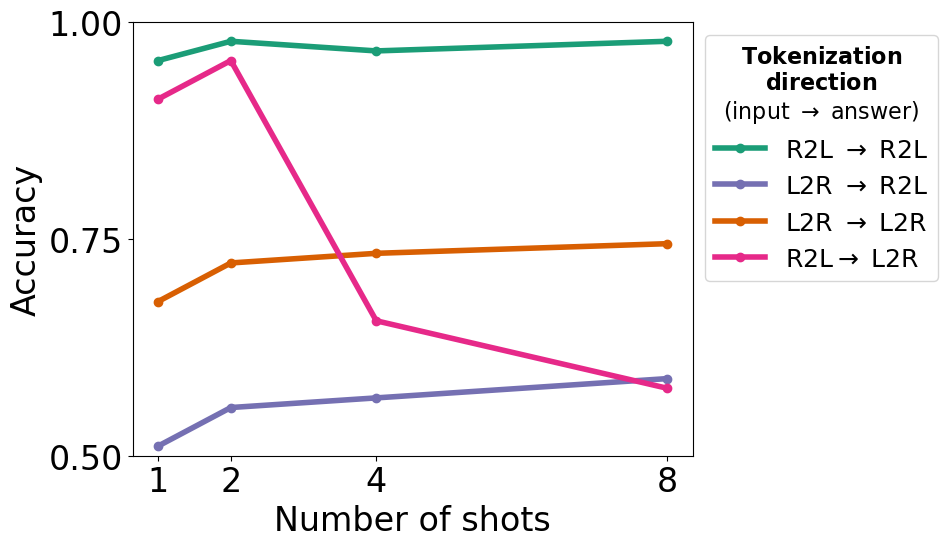

In [42]:
# matplotlib style figure matching other paper figures
save_fig = False
plot_dict = {}
shots = [1,2,4,8]
for problem_format in problem_formats.values():
    plot_dict[problem_format] = []
    for num_shots in shots:
        plot_dict[problem_format].append(filtered_df.loc[(filtered_df['problem_format'] == problem_format) & (filtered_df['num_shots'] == num_shots)]['answer_match_mean'].to_numpy()[0])
    
fig, axs = plt.subplots()
fig.set_size_inches(10, 6)
axs.plot(shots, plot_dict['R2L -> R2L'], color=green, label='R2L $\\rightarrow$ R2L', lw=4, marker='o')
axs.plot(shots, plot_dict['L2R -> R2L'], color=purple, label='L2R $\\rightarrow$ R2L', lw=4, marker='o')
axs.plot(shots, plot_dict['L2R -> L2R'], color=orange, label='L2R $\\rightarrow$ L2R', lw=4, marker='o')
axs.plot(shots, plot_dict['R2L -> L2R'], color=pink, label='R2L$\\rightarrow$ L2R', lw=4, marker='o')
axs.legend(bbox_to_anchor=(1,1), fontsize=18, title='$\\bf{Tokenization}$\n$\\bf{direction}$\n(input $\\rightarrow$ answer)', title_fontsize=16).get_title().set_multialignment('center')
axs.set_xlabel('Number of shots')
axs.set_ylabel('Accuracy')
axs.set_ylim([0.5, 1])
axs.set_yticks([0.5, 0.75, 1])
axs.set_xticks([1, 2, 4, 8])
plt.tight_layout()
if save_fig:
  fig.savefig('figures/answer_style.pdf')

# Section 6: Newer model comparisons

## Main result -- difference between nosep and comma_r2l

In [43]:
df35_0301 = pd.read_csv('results/20230407_gpt35_comma_effects.csv', index_col=0)

df35_0301 = df35_0301[(df35_0301['num_shots'] == 8) & 
                       (df35_0301['problem_number_format'].isin(['nosep', 'comma_r2l'])) &
                       (df35_0301['num_spaces'] == 0) & 
                       (df35_0301['system_prompt'] == 'You are a helpful assistant.')]

df4_0314 = pd.read_csv('results/20230502_gpt4_comma_effects.csv', index_col=0)

df4_0314 = df4_0314[(df4_0314['num_shots'] == 8) & 
                       (df4_0314['problem_number_format'].isin(['nosep', 'comma_r2l'])) &
                       (df4_0314['num_spaces'] == 0) & 
                       (df4_0314['system_prompt'] == 'You are a helpful assistant.')]

df_new = pd.read_csv('results/20240125_run_gpt_comma_effects_repeat_style_triplets_new_models.csv', index_col=0)
df_new = df_new[(df_new['num_shots'] == 8) & 
                df_new['repeat_problem_number_format'].isna() &
               (df_new['problem_number_format'] == df_new['answer_number_format'])]

df_1106 = pd.read_csv('results/20240129_run_gpt1106_comma_effects_repeat_style_triplets_new_models.csv', index_col=0)
df_1106 = df_1106[(df_new['num_shots'] == 8) & 
                df_1106['repeat_problem_number_format'].isna() &
               (df_1106['problem_number_format'] == df_1106['answer_number_format'])]

df = pd.concat([df35_0301, df4_0314, df_new, df_1106], axis=0).reset_index(drop=True)

In [44]:
df = utils.post_process_df(df)

In [45]:
results = dict()
models = ['gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106',
          'gpt-4-0314', 'gpt-4-0613', 'gpt-4-1106-preview']
for series in ['nosep', 'comma_r2l']:
    results[series] = [df[(df['model'] == model) & 
                          df['valid_answer'] &
                          (df['problem_number_format'] == series)]['answer_match'].mean()
                      for model in models]
print(results)

{'nosep': [0.7444444444444445, 0.7444444444444445, 0.7303370786516854, 0.8444444444444444, 0.9888888888888889, 0.9325842696629213], 'comma_r2l': [0.9777777777777777, 0.9888888888888889, 0.9746835443037974, 0.9888888888888889, 1.0, 0.9887640449438202]}


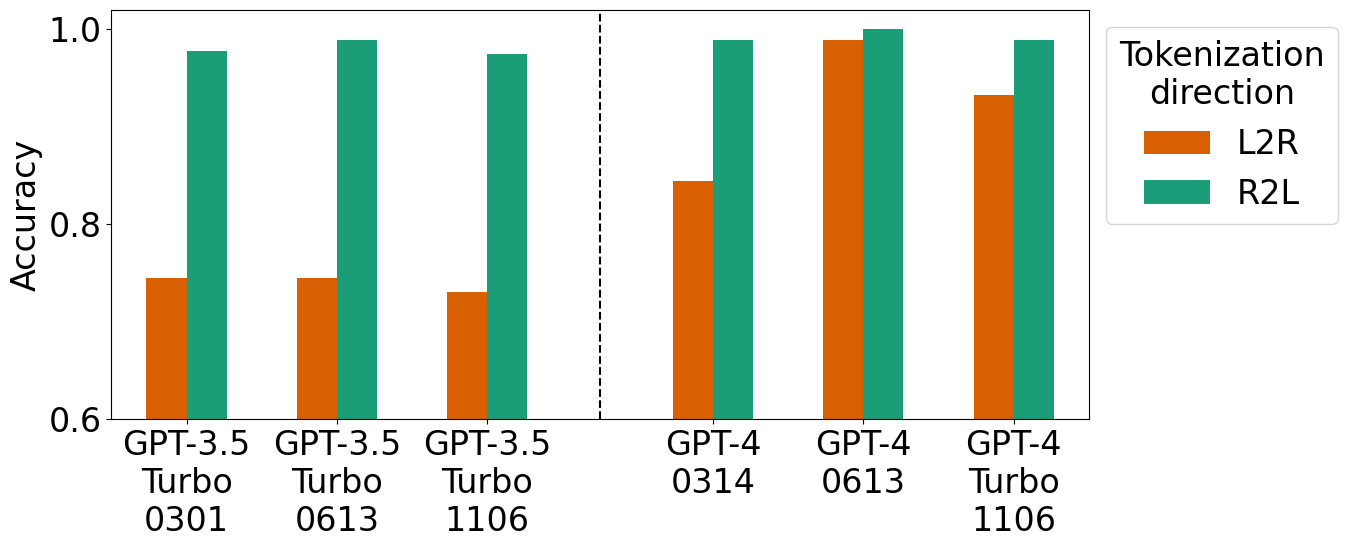

In [46]:
fig, axs = plt.subplots()
fig.set_size_inches(14,6)

x = np.array([0, 3, 6, 10.5, 13.5, 16.5])
axs.bar(x-0.4, results['nosep'], width=0.8, color=orange, label='L2R')
axs.bar(x+0.4, results['comma_r2l'], width=0.8, color=green, label='R2L')
axs.set_xlim(-1.5, 18)
axs.set_xticks(x, ["GPT-3.5\nTurbo\n0301", "GPT-3.5\nTurbo\n0613", "GPT-3.5\nTurbo\n1106",
                   "GPT-4\n0314", "GPT-4\n0613", "GPT-4\nTurbo\n1106"])
axs.set_yticks([0.6, 0.8, 1])
axs.set_ylim([0.6, 1.02])
axs.set_ylabel("Accuracy")
axs.legend(bbox_to_anchor=(1,1), title='Tokenization\ndirection').get_title().set_multialignment('center')
axs.axvline(8.25, c='k', ls='--')

plt.tight_layout()
fig.savefig('figures/accuracy_diff_tokenization_new_models_v2.pdf')

## Error analysis -- to what extent do newer models show the same error patterns?

In [47]:
df35_0301 = pd.read_csv('results/20240125_gpt35_0301_answer_length_effects.csv', index_col=0)

df_0613 = pd.read_csv('results/20240125_gpt_answer_length_effects_new_models.csv', index_col=0)

df_4_1106 = pd.read_csv('results/20240125_gpt4_turbo_answer_length_effects_new_models.csv', index_col=0)
df_35_1106 = pd.read_csv('results/20240130_gpt35_1106_answer_length_effects_new_models.csv', index_col=0)

df = pd.concat([df35_0301, df_0613, df_35_1106, df_4_1106], axis=0).reset_index(drop=True)
df = utils.post_process_df(df)

df = pd.concat([utils.add_error_analysis(df[df['problem_number_format'] == 'nosep']),
               utils.add_error_analysis(df[df['problem_number_format'] == 'comma_r2l'], tokenize_dir='r2l')],
              axis=0)

In [48]:
results = dict()
models = ['gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106',
          'gpt-4-0613', 'gpt-4-1106-preview']
# Note we restrict to valid answer here since we found especially gpt 3.5 1106
# doesn't follow the few shot prompt and starts using text (leading to invalid answer)
# This was artificially deflating its accuracy.
for series in ['nosep', 'comma_r2l']:
    for b in [True, False]:
        k = series+'_'+str(b)
        results[k] = []
        for model in models:
            results[k].append(df[(df['model'] == model) & 
                                        (df['problem_number_format'] == series) & 
                                        (df['valid_answer']) & 
                                        (df['len_match'] == b)]['answer_match'].mean())
print(results)

{'nosep_True': [0.9377777777777778, 0.9377777777777778, 0.9255555555555556, 0.9666666666666667, 0.9131428571428571], 'nosep_False': [0.08270676691729323, 0.09523809523809523, 0.1125, 0.9175, 0.6746666666666666], 'comma_r2l_True': [0.9788888888888889, 0.9822222222222222, 0.9831387808041504, 0.9977777777777778, 0.9887133182844243], 'comma_r2l_False': [0.985, 0.995, 0.981651376146789, 1.0, 1.0]}


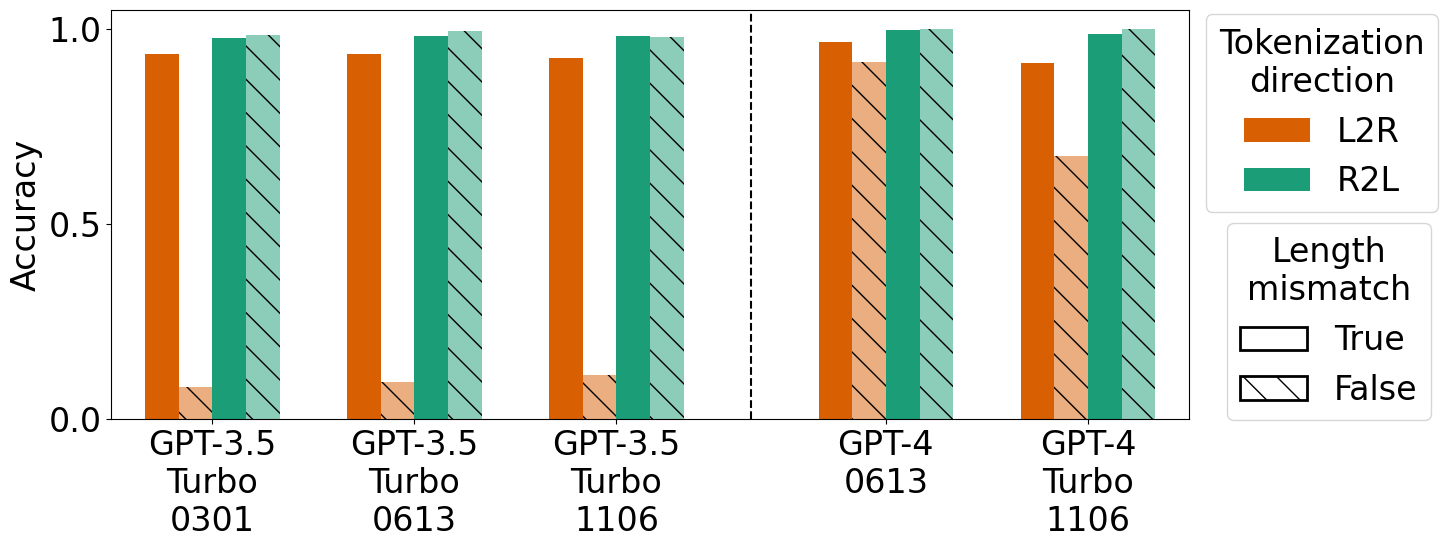

In [49]:
fig, axs = plt.subplots()
fig.set_size_inches(15,6)

x = np.array([0, 6, 12, 20, 26])
bar1 = axs.bar(x-1.5, results['nosep_True'], width=1, color=orange, label='L2R')
axs.bar(x-0.5, results['nosep_False'], width=1, color=list(orange)+[0.5], hatch="\\")
bar2 = axs.bar(x+0.5, results['comma_r2l_True'], width=1, color=green, label='R2L')
axs.bar(x+1.5, results['comma_r2l_False'], width=1, color=list(green)+[0.5], hatch="\\")

other_bars = []
other_bars.append(axs.bar([100], [0.5], width=1, color='none', label='True', edgecolor='k', lw=2))
other_bars.append(axs.bar([100], [0.5], width=1, color='none', label='False', hatch="\\", edgecolor='k', lw=2))

axs.set_xlim(-3, 29)
axs.set_xticks(x, ["GPT-3.5\nTurbo\n0301", "GPT-3.5\nTurbo\n0613", "GPT-3.5\nTurbo\n1106",
                   "GPT-4\n0613", "GPT-4\nTurbo\n1106"])
axs.set_yticks([0, 0.5, 1])
axs.set_ylabel("Accuracy")

axs.axvline(16, c='k', ls='--')

legend2 = axs.legend(handles=other_bars, title='Length\nmismatch', 
                     bbox_to_anchor=(1.02,0.02,0.5,0.5), loc='upper left')
legend2.get_title().set_multialignment('center')

axs.add_artist(legend2)

legend1 = axs.legend(handles=[bar1, bar2], title='Tokenization\ndirection', 
                     bbox_to_anchor=(1,0.53,0.5,0.5), loc='upper left')
legend1.get_title().set_multialignment('center')
plt.tight_layout()
fig.savefig('figures/accuracy_diff_len_match_fourcol_v2.pdf')

# Appendix C Frequency bias?

## GPT-3.5 has a slight preference to outputting a more frequent token

In [50]:
df = pd.read_csv('results/20240125_gpt35_0301_answer_length_effects.csv', index_col=0)
df = utils.post_process_df(df)

In [51]:
df = pd.concat([utils.add_error_analysis(df[df['problem_number_format'] == 'nosep']),
               utils.add_error_analysis(df[df['problem_number_format'] == 'comma_r2l'], tokenize_dir='r2l')],
              axis=0)

In [52]:
df.groupby(['problem_number_format', 
            'len_match'])[['token_1_error', 'token_1_error_more_frequent', 
                           'token_2_error', 'token_2_error_more_frequent',
                           'answer_match', 'digit_4_error', 
                           'token_3_error', 'token_3_error_more_frequent'
                          ]].agg([lambda x: (np.sum(x.astype(float)))])

token_1_error token_1_error_more_frequent   
                                     <lambda>                    <lambda>   
problem_number_format len_match                                             
comma_r2l             False               2.0                         2.0  \
                      True               13.0                         8.0   
nosep                 False               1.0                         0.0   
                      True               32.0                        21.0   

                                token_2_error token_2_error_more_frequent   
                                     <lambda>                    <lambda>   
problem_number_format len_match                                             
comma_r2l             False               4.0                         2.0  \
                      True                6.0                         3.0   
nosep                 False             366.0                       207.0   
                      True               26.0                        10.0   

                                answer_match digit_4_error token_3_error   
                                    <lambda>      <lambda>      <lambda>   
problem_number_format len_match                                            
comma_r2l             False            394.0           0.0           0.0  \
                      True             881.0           0.0           0.0   
nosep                 False             33.0         366.0           1.0   
                      True             844.0           2.0           1.0   

                                token_3_error_more_frequent  
                                                   <lambda>  
problem_number_format len_match                              
comma_r2l             False                             0.0  
                      True                              0.0  
nosep                 False                             1.0  
                      True                              1.0

In [53]:
# 207 + 10 + 21 = 238
# 366 + 26 + 32 + 1 = 425
1 - binom.cdf(238, 425, 0.5), 1 - binom.cdf(15, 25, 0.5)

(0.005784318389169929, 0.11476147174835205)

## Distribution of frequency rank for digit 4 error token substitution

Of the 10 tokens that could occur as the second token (with digit 4 = first digit of second token possibly wrong), we rank them in order of rough frequency (using BPE merge ranks), and then make a bar plot

In [54]:
# df_nosep_nolenmatch_wrong_correctlen was defined earlier, in Section 4.3
# It was not overwritten since then, so this works
ranks = df_nosep_nolenmatch_wrong_correctlen.groupby('token_2_picked_rank_off_first_digit')['problem_index'].nunique().to_dict()
raw_ranks = np.array([ranks[i] for i in range(10)])
all_ranks = raw_ranks/len(df_nosep_nolenmatch_wrong)
print(ranks, all_ranks)

{0.0: 58, 1.0: 47, 2.0: 24, 3.0: 53, 4.0: 26, 5.0: 27, 6.0: 30, 7.0: 39, 8.0: 22, 9.0: 36} [0.15803815 0.1280654  0.0653951  0.14441417 0.07084469 0.07356948
 0.08174387 0.10626703 0.0599455  0.09809264]


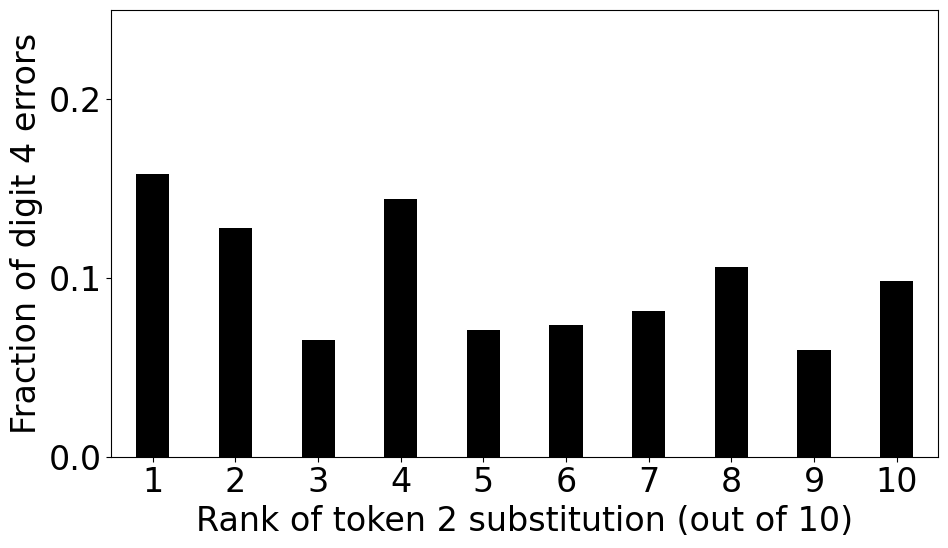

In [55]:
fig, axs = plt.subplots()
fig.set_size_inches(10,6)

x = np.arange(len(all_ranks))

axs.bar(x, all_ranks, width=0.4, color='k')
axs.set_xlim(-0.5, x[-1]+0.5)
axs.set_xticks(x, [str(i) for i in range(1,11)])
axs.set_ylim([0, 0.25])
axs.set_yticks([0, 0.1, 0.2])
axs.set_ylabel("Fraction of digit 4 errors")
axs.set_xlabel("Rank of token 2 substitution (out of 10)")

plt.tight_layout()
fig.savefig('figures/len_mismatch_token2_substitution_rank.pdf', bbox_inches='tight', pad_inches=0)

## Off-by-one errors do not seem correlated to frequency rank

In [56]:
for t in [1,2,3]:
    temp = df[(df['problem_number_format'] == 'comma_r2l') &
               (df['answer_match'] == False) & 
               df['only_off_by_one'] & df[f'token_{t}_error']]
    print(len(temp), 
          temp[f'token_{t}_match_most_frequent_off_by_one_last_digit'].sum(),
         temp[f'token_{t}_error_more_frequent'].sum())

14 3 10
10 4 5
0 0 0


In [57]:
for t in [1,2,3]:
    temp = df[(df['problem_number_format'] == 'nosep') &
               (df['answer_match'] == False) & 
                df['len_match'] & # we only want the non digit 4 errors here
               df['only_off_by_one'] & df[f'token_{t}_error']]
    print(len(temp), 
          temp[f'token_{t}_match_most_frequent_off_by_one_last_digit'].astype(int).sum(),
         temp[f'token_{t}_error_more_frequent'].sum())

29 13 19
24 4 9
1 0 True


Chance level for the first column would be 1/3, and second column would be 1/2, which is roughly what we see (e.g. 17/53 and 28/53 for L2R match case, second box)

# Appendix D Log probabilities

We reuse the same df as it already has error analysis added

In [58]:
conditions = dict()
conditions['nosep_mismatch'] = df[(df['problem_number_format'] == 'nosep') & 
                                  (df['len_match'] == False)]
conditions['nosep_match'] = df[(df['problem_number_format'] == 'nosep') & 
                               (df['len_match'] == True)]
conditions['comma_r2l'] = df[df['problem_number_format'] == 'comma_r2l']

## Entropy on digit 4 errors

In [59]:
conditions['nosep_mismatch'].groupby('answer_match')[['token_1_lower_entropy', 
                                                      'token_2_lower_entropy',
                                                      'token_3_lower_entropy']
                                                    ].agg([np.mean]).T

,answer_match,False,True
token_1_lower_entropy,mean,0.001019,0.000614
token_2_lower_entropy,mean,2.065553,2.061202
token_3_lower_entropy,mean,0.004827,0.000177


## Entropy on off-by-one errors

In [60]:
# Since off-by-one errors appear in either the first or second token mostly,
# we group by where the error is
conditions['nosep_match'].groupby(['answer_match', 
                                   'token_1_error',
                                   'token_2_error'])[['token_1_lower_entropy',
                                                      'token_2_lower_entropy']
                                                    ].agg([np.mean]).T

answer_match                   False                         True 
token_1_error                  False     True                False
token_2_error                  True      False     True      False
token_1_lower_entropy mean  0.001397  0.429366  0.545768  0.023276
token_2_lower_entropy mean  0.492997  0.049919  0.481882  0.053552

In [61]:
# Since off-by-one errors appear in either the first or second token mostly,
# we group by where the error is
conditions['comma_r2l'].groupby(['answer_match', 
                                   'token_1_error',
                                   'token_2_error'])[['token_1_lower_entropy',
                                                      'token_2_lower_entropy']
                                                    ].agg([np.mean]).T

answer_match                   False               True 
token_1_error                  False     True      False
token_2_error                  True      False     False
token_1_lower_entropy mean  0.000212  0.485826  0.009422
token_2_lower_entropy mean  0.465235  0.001991  0.011666

## GPT-3.5 is more confidently correct when using R2L tokenization

In [62]:
overlap_correct_inds = set(conditions['comma_r2l'][conditions['comma_r2l']['answer_match']]['problem_index']).intersection(set(conditions['nosep_match'][conditions['nosep_match']['answer_match']]['problem_index']))

Sanity check 0.025613540966390316
0.025613540966390312 0.10143254219840901


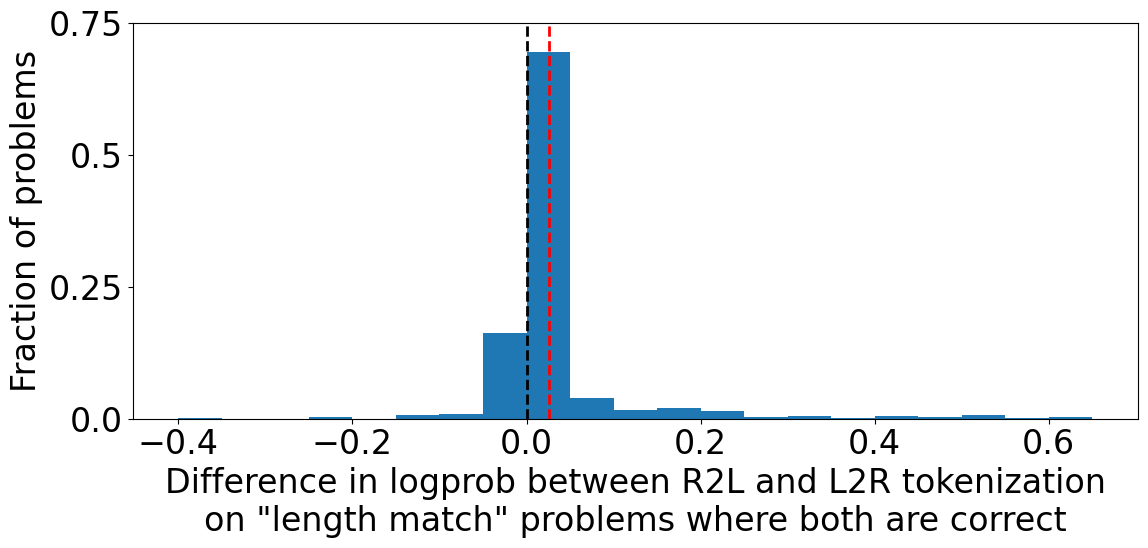

In [63]:
overlap_comma = conditions['comma_r2l'][conditions['comma_r2l']['problem_index'].isin(overlap_correct_inds)].reset_index(drop=True)
overlap_nosep = conditions['nosep_match'][conditions['nosep_match']['problem_index'].isin(overlap_correct_inds)].reset_index(drop=True)

print("Sanity check", overlap_comma['answer_logprob'].mean() - overlap_nosep['answer_logprob'].mean())
# We can use the fact that df's are sorted by problem index
diffs = (overlap_comma['answer_logprob'] - overlap_nosep['answer_logprob']).to_numpy()
print(np.mean(diffs), np.std(diffs))

fig,axs = plt.subplots()
fig.set_size_inches(12,6)
axs.hist(diffs, bins=np.arange(-0.4, 0.7, 0.05))
ticks = np.array([0, 0.25, 0.5, 0.75])
axs.set_yticks(ticks*len(overlap_correct_inds), ticks)
axs.set_ylabel('Fraction of problems')
axs.set_xlabel('Difference in logprob between R2L and L2R tokenization\non "length match" problems where both are correct')
axs.axvline(np.mean(diffs), c = 'r', ls='--', lw=2)
axs.axvline(0, c = 'k', ls='--', lw=2)

plt.tight_layout()
fig.savefig('figures/correct_logprob_diff_across_tokenization.pdf')